# Final Project: Spiking Neural Networks

**Due:** Dec. 10, 2025  |  **Author:** James Levi

Use this notebook to implement and document your work.

## Project Overview

Spiking neural networks project based on Baek & Farhat, "Approach to invariant feature extraction and segmentation for ATR" (SPIE). Read the paper (PDF on Canvas) and follow the tasks below. Keep notes and results in this notebook without altering the original assignment text.

## Task 1: Simulate the Paper's Neural Network

Develop a computer code to simulate the neural network discussed in the paper (page 5, Figure 2). The dynamics of the neural network are explained mostly on page 3 in Equations 1 to 7 and Fig. 1. Try to reproduce the histograms shown in Figures 3, 4, and 5. This architecture has a special ability to generate histograms that do not change even when the objects in the pictures are scaled or rotated. Why? Explain.

## Task 2: Apply the Architecture to Digit Images

Develop this architecture and apply it to the digit pictures used in the prior multilayer perceptron classification project. For each digit picture, generate the histogram. How much does this histogram change when you stimulate the network with different pictures of the same digit? Try this for different digits from 0 to 9. For each digit, generate an average histogram. Can you feed these histograms to a classifier instead of the raw picture for pattern classification? Would that be a good idea? Explain.

## Task 3: Rotation and Scaling Experiments

Generate rotated and scaled versions of the digit pictures from your database and produce the histograms. Do you see similarities between the histogram of the original pictures and the rotated or scaled versions?

## Task 4: Edge and Corner Extraction

Figures 6-10 show that the neural network is capable of extracting edges or even corners. Why can this network extract edges and corners? Explain.

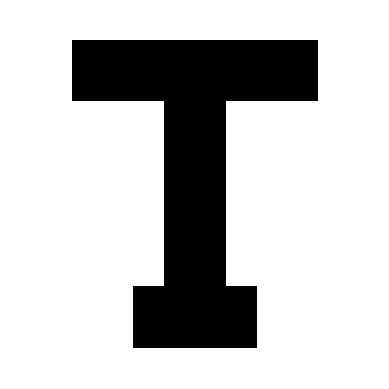

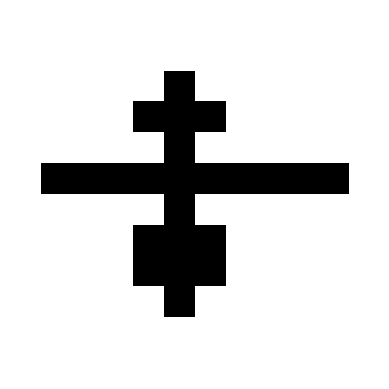

In [1]:
import numpy as np
import matplotlib.pyplot as plt



tee = np.zeros((12,12))
tee[1:3, 2:10] = 1
tee[3:11, 5:7] = 1
tee[9:11, 4:8] = 1


cross = np.zeros((12,12))
cross[2:10, 5] = 1
cross[5, 1:11] = 1
cross[3, 4:7] = 1
cross[7:9, 4:7] = 1


rect = np.zeros((12,12))
rect[2, 3:9] = 1
rect[9, 3:10] = 1
rect[2:10, 3] = 1
rect[3:10, 9] = 1
rect[4:7, 10] = 1


tri = np.zeros((12,12))
tri[1,6] = 1
for r in range(2,11):
    left = 6 - (r//2) - (r%2==0)
    right = 6 + (r//3) + (r%3==0)
    tri[r, left:right+1] = 1
tri[10, 2:11] = 1
tri[11, 3:10] = 1

def show_img(a2d, ttl=None):
    plt.imshow(a2d, cmap='gray_r')
    if ttl is not None:
        plt.title(ttl)
    plt.axis("off")
    plt.show()

show_img(tee)
show_img(cross)

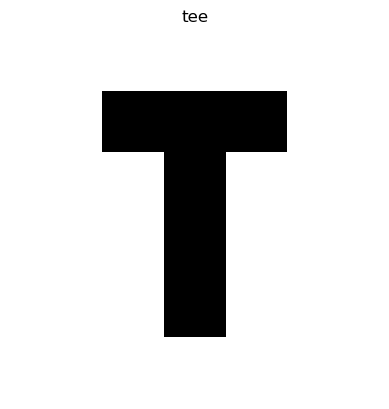

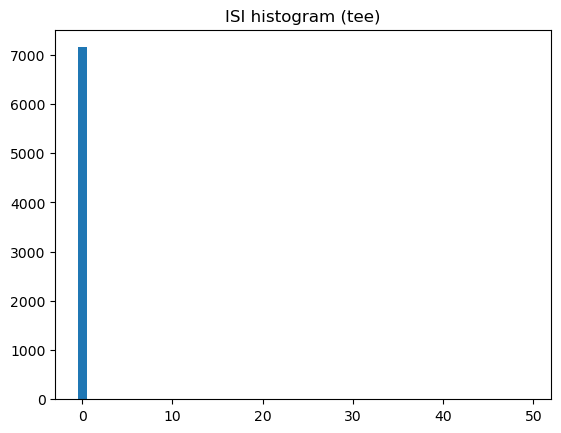

In [ ]:
class SpikeCell:
    def __init__(self, Iv, beta, mu, tau, V0, Vr, E):
        self.Iv = Iv
        self.beta = beta
        self.mu = mu
        self.tau = tau
        self.V0 = V0
        self.Vr = Vr
        self.E = E
        self.Vm = Vr
        self.thr = V0
        self.P = 0.0
        self.spks = []
        self.nb = []

    def upd_syn(self):
        self.P = self.P * np.exp(-1.0/self.tau)
        if len(self.nb) > 0:
            self.P += np.sum(self.nb)
        self.nb = []

    def upd_thr(self):
        U = self.Iv * (1 + self.beta*self.P)
        self.thr = self.V0 - U

    def upd_mem(self):
        step = (self.E - self.Vm) * (1 - np.exp(-1.0/self.mu))
        self.Vm += step

    def check_spk(self, t):
        if self.Vm >= self.thr:
            self.spks.append(t)
            self.Vm = self.Vr
            return 1
        return 0

def nb_idx(i, j, N=12):
    out = []
    for a in [-1,0,1]:
        for b in [-1,0,1]:
            if a==0 and b==0: continue
            ii, jj = i+a, j+b
            if ii>=0 and ii<N and jj>=0 and jj<N:
                out.append((ii,jj))
    return out

def build_net(img):
    beta = 0.2
    mu = 1.0
    tau = 12.0
    V0 = 5.0
    Vr = 1.0
    E = 4.8
    net = []
    for i in range(12):
        row = []
        for j in range(12):
            row.append(SpikeCell(img[i,j], beta, mu, tau, V0, Vr, E))
        net.append(row)
    return net

def run_sim(img, T=250):
    net = build_net(img)
    for t in range(T):
        for i in range(12):
            for j in range(12):
                net[i][j].upd_syn()
        for i in range(12):
            for j in range(12):
                net[i][j].upd_thr()
        for i in range(12):
            for j in range(12):
                net[i][j].upd_mem()
        fired = []
        for i in range(12):
            for j in range(12):
                if net[i][j].check_spk(t)==1:
                    fired.append((i,j))
        for (i,j) in fired:
            for (ii,jj) in nb_idx(i,j):
                net[ii][jj].nb.append(1)

    isi_all = []
    for i in range(12):
        for j in range(12):
            sp = net[i][j].spks
            if len(sp)>=2:
                d = np.diff(sp)
                isi_all.extend(d)

    isi_all = np.array(isi_all)
    h, b = np.histogram(isi_all, bins=np.linspace(0,50,50))

    return isi_all, h, b


isi_vals, hist, bins_used = run_sim(tee, T=300)

plt.bar(bins_used[:-1], hist, width=1.0)
plt.title("ISI histogram (tee)")
plt.show()
